In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
    label_binarize,
    OrdinalEncoder,
)
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import (
    RidgeClassifier,
    LogisticRegression,
    LinearRegression,
    Ridge,
    BayesianRidge,
)

from sklearn import set_config
import os

import optuna
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    precision_recall_curve,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    matthews_corrcoef,
    mean_absolute_percentage_error,
)
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    KFold,
    RepeatedKFold,
    cross_val_score,
    StratifiedGroupKFold,
    GroupKFold,
)
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import (
    log_evaluation,
    early_stopping,
    LGBMClassifier,
    LGBMRegressor,
    Dataset,
)
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re
import holidays
import requests

import warnings

warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
import warnings
import os
import plotly.graph_objects as go

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# os.listdir()
class Config:
    model_round_ = 5
    state = 52943
    n_splits = 5
    early_stop = 200
    target = "num_sold"
    train = pd.concat(
        [
            pd.read_csv("./datadown/train.csv", index_col="id"),
            pd.read_csv("./dataup/f_X_extra_features_nomodel.csv", index_col=0),
        ],
        axis=1,
    )
    tfs =  pd.read_csv("./dataup/f_test_extra_features_nomodel.csv", index_col=0)
    tfs.index = range(230130,230130+98550)
    test = pd.concat(
        [
            pd.read_csv("./datadown/test.csv", index_col="id"),
            tfs
        ],
        axis=1,
    )
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    submission = pd.read_csv("./datadown/sample_submission.csv")
    original_data = "N"
    outliers = "N"
    log_trf = "Y"
    scaler_trf = "N"
    feature_eng = "Y"
    missing = "Y"

In [3]:
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", parse_dates=["date"])
except:
    train_df = pd.read_csv("./datadown/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("./datadown/test.csv", parse_dates=["date"])
gdp_per_capita_df = pd.read_csv("./datadown/gdp_per_capita.csv")
years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')


In [3]:
# X[
#     [
#         "day_of_week_ratios",
#         "country_ratio",
#         "product_ratio",
#         "store_ratio",
#         "num_sold_pseudo_label",
#     ]
# ].to_csv('./dataup/f_X_extra_features_nomodel.csv')
# nomodel_sub[
#     [
#         "day_of_week_ratios",
#         # "adjusted_num_sold",
#         "country_ratio",
#         "product_ratio",
#         "store_ratio",
#         "num_sold",
#     ]
# ].to_csv('./dataup/f_test_extra_features_nomodel.csv')

In [4]:
class Transform(Config):

    def __init__(self):
        super().__init__()
        if Config.original_data == "Y":
            self.train = pd.concat(
                [self.train, self.train_org], ignore_index=True
            ).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )
        self.train_raw = self.train.copy()
        # self.num_features = list(set(self.num_features + cbcs_))

        if self.feature_eng == "Y":
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)

        if self.missing == "Y":
            self.missing_values()

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )
        if self.outliers == "Y":
            self.remove_outliers()

        if self.log_trf == "Y":
            self.log_transformation()

        if self.scaler_trf == "Y":
            self.scaler()

        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()

        # if self.outliers == "Y" or self.log_trf == "Y" or self.scaler_trf == "Y":
        #     self.distribution()

    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype("category")
        self.test[self.cat_features] = self.test[self.cat_features].astype("category")

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

        return (
            self.train,
            self.train_enc,
            self.y,
            self.test,
            self.test_enc,
            self.cat_features,
        )

    def encode(self):
        data = pd.concat([self.test, self.train], axis = 0)
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype(
            "int"
        )
        # print(self.num_features)
        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(
            data[self.num_features + [self.target]]
        )

        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)


    def new_features(self, data):
        data["date"] = pd.to_datetime(data["date"])
        data["quarter"] = data["date"].dt.quarter.astype("object")
        data["month"] = data["date"].dt.month
        data["month_sin"] = np.sin(data["month"] * (2 * np.pi / 12))
        data["month_cos"] = np.cos(data["month"] * (2 * np.pi / 12))
        data["day"] = data["date"].dt.day
        data["day_sin"] = np.sin(data["day"] * (2 * np.pi / 31))
        data["day_cos"] = np.cos(data["day"] * (2 * np.pi / 31))
        data["day_of_week"] = data["date"].dt.dayofweek.astype("object")
        data["day_of_year"] = data["date"].dt.dayofyear.astype("object")
        # data["day_of_week"] = data["day_of_week"].apply(
        #     lambda x: 0 if x <= 3 else (1 if x == 4 else (2 if x == 5 else (3)))
        # )
        data["week"] = data["date"].dt.isocalendar().week
        data["week_sin"] = np.sin(data["week"] * (2 * np.pi / 53))
        data["week_cos"] = np.cos(data["week"] * (2 * np.pi / 53))
        data["year"] = data["date"].dt.year
        data["cos_year"] = np.cos(data["year"] * (2 * np.pi) / 100)
        data["sin_year"] = np.sin(data["year"] * (2 * np.pi) / 100)
        data[["month", "day", "week", "year"]] = data[
            ["month", "day", "week", "year"]
        ].astype("object")
        data["group"] = (
            (data["year"] - 2020) * 48 + data["month"] * 4 + data["day"] // 7
        )
        data = pd.get_dummies(data, columns=["day_of_week"], drop_first=True)
        data["important_dates"] = data["day_of_year"].apply(
            lambda x: (
                x
                if x
                in [
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    99,
                    100,
                    101,
                    125,
                    126,
                    355,
                    256,
                    357,
                    358,
                    359,
                    360,
                    361,
                    362,
                    363,
                    364,
                    365,
                ]
                else 0
            )
        )
        data.drop(columns=["day_of_year"], inplace=True)
        for day in range(24, 32):
            data[f"dec{day}"] = (
                (data.date.dt.day.eq(day) & data.date.dt.month.eq(12))
                .astype(np.uint8)
                .astype("object")
            )
        alpha2 = dict(
            zip(np.sort(data.country.unique()), ["CA", "FI", "IT", "KE", "NO", "SG"])
        )
        h = {
            c: holidays.country_holidays(a, years=range(2010, 2020))
            for c, a in alpha2.items()
        }
        data["is_holiday"] = 0
        for c in alpha2:
            data.loc[data.country == c, "is_holiday"] = (
                data.date.isin(h[c]).astype(int).astype("object")
            )

        try:
            gdp_df = pd.read_csv(
                "./datadown/gdp_df.csv"
            )  # .drop('Unnamed: 0', axis = 1)
        except:
            print("no gdp data")
            gdp = []
            for country in data.country.unique():
                row = []
                for year in range(2010, 2020):
                    row.append(self.get_gdp(country, year))
                gdp.append(row)

            gdp = np.array(gdp)
            gdp /= np.sum(gdp, axis=0)

            gdp_df = pd.DataFrame(
                gdp, index=data.country.unique(), columns=range(2010, 2020)
            )
            gdp_df = (
                gdp_df.reset_index()
                .melt(id_vars=["index"])
                .rename(
                    {"index": "country", "variable": "year", "value": "GDP"}, axis=1
                )
            )
        data = data.merge(gdp_df, how="left", on=["year", "country"])
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target])
        return self

    def distribution(self):
        print(Style.BRIGHT + Fore.GREEN + f"\nHistograms of distribution\n")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        ax_r, ax_n = axes

        ax_r.set_title(
            f"{self.target} ($\mu=$ {self.train_raw[self.target].mean():.2f} and $\sigma=$ {self.train_raw[self.target].std():.2f} )"
        )
        ax_r.hist(self.train_raw[self.target], bins=30, color="#3cb371")
        ax_r.axvline(self.train_raw[self.target].mean(), color="r", label="Mean")
        ax_r.axvline(
            self.train_raw[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_r.legend()

        ax_n.set_title(
            f"{self.target} Normalized ($\mu=$ {self.train_enc[self.target].mean():.2f} and $\sigma=$ {self.train_enc[self.target].std():.2f} )"
        )
        ax_n.hist(self.train_enc[self.target], bins=30, color="#3cb371")
        ax_n.axvline(self.train_enc[self.target].mean(), color="r", label="Mean")
        ax_n.axvline(
            self.train_enc[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        self.train = self.train[
            (self.train[self.targets] >= lower_limit)
            & (self.train[self.targets] <= upper_limit)
        ]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self, cols: [] = None):
        scaler = StandardScaler()
        self.train[cols] = scaler.fit_transform(self.train[cols])
        self.test[cols] = scaler.transform(self.test[cols])
        return self

    def missing_values(self):
        train_df_imputed = self.train.copy()
        for year in train_df_imputed["year"].unique():
            target_ratio = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Norway"),
                "GDP",
            ].values[0]
            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Canada"),
                "GDP",
            ].values[0]
            ratio_can = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Kenya"),
                "GDP",
            ].values[0]
            ratio_ken = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Kerneler")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

        train_df_imputed.loc[train_df_imputed.index == 23719, "num_sold"] = 4
        train_df_imputed.loc[train_df_imputed.index == 207003, "num_sold"] = 195
        self.train = train_df_imputed.drop("date", axis=1)
        self.test.drop("date", axis=1, inplace=True)
        # * samo mutate year to int.,
        self.train["year"] = self.train["year"].astype(int) - 2010
        self.test["year"] = self.test["year"].astype(int) - 2010
        self.train["group"] = self.train["group"].astype(int)
        self.test["group"] = self.test["group"].astype(int)
        return self

    def reduce_mem(self, df):

        numerics = [
            "int16",
            "int32",
            "int64",
            "float16",
            "float32",
            "float64",
            "uint16",
            "uint32",
            "uint64",
        ]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif (
                        c_min >= np.iinfo(np.int16).min
                        and c_max < np.iinfo(np.int16).max
                    ):
                        df[col] = df[col].astype(np.int16)
                    elif (
                        c_min >= np.iinfo(np.int32).min
                        and c_max < np.iinfo(np.int32).max
                    ):
                        df[col] = df[col].astype(np.int32)
                    elif (
                        c_min >= np.iinfo(np.int64).min
                        and c_max < np.iinfo(np.int64).max
                    ):
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min >= np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    if (
                        c_min >= np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

    def get_gdp(self, country, year):
        alpha3 = {
            "Canada": "CAN",
            "Finland": "FIN",
            "Italy": "ITA",
            "Kenya": "KEN",
            "Norway": "NOR",
            "Singapore": "SGP",
        }

        url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
            alpha3[country], year
        )
        response = requests.get(url).json()
        return response[1][0]["value"]

In [5]:
# 15 sec  
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

In [6]:
for j in range(len(cat_features)):
    # print(j)
    unique_values = test_enc[cat_features[j]].unique()
    # print(f"Feature {cat_features[j]}: Unique values = {unique_values}")
    assert min(unique_values) >= 0, ''
    assert max(unique_values) < t.cat_features_card[j], ''
t.cat_features == cat_features

True

In [7]:
def plot_data(train, y):
    C = list(train.country.unique())
    S = list(train.store.unique())
    P = list(train["product"].unique())
    print("Countries:", C)
    print("Stores:", S)
    print("Products:", P)

    # DATA IS PRODUCT X 7 YEARS X STORE+COUNTRY
    data = np.zeros((5, 2557, 18))
    for i in range(5):
        for j in range(3):
            for k in range(6):
                f = 1
                if k == 3:
                    f = 1.15  # FUDGE FACTOR FOR KENYA
                df = train.loc[
                    (train.country == C[k])
                    & (train.store == S[j])
                    & (train["product"] == P[i])
                ].copy()
                
                data[i, :, j * 6 + k] = y[df.index].values * f

    # COMPUTE MEANS AND STDS
    means = {}
    stds = {}
    for k in range(5):
        m = np.nanmean(data[k, :, :])
        s = np.nanstd(data[k, :, :])
        means[k] = m
        stds[k] = s

    # PLOT ALL TIME SERIES DATA
    for i in range(5):
        plt.figure(figsize=(10, 5))
        for j in range(3):
            for k in range(6):
                f = 1
                if k == 3:
                    f = 1.15
                df = train.loc[
                    (train.country == C[k])
                    & (train.store == S[j])
                    & (train["product"] == P[i])
                ].copy()
                df["smooth_sold"] = y.rolling(window=180).mean()
                m = means[i]
                s = stds[i]
                plt.plot(df["date"], (df["smooth_sold"] * f - m) / s)
                data[i, :, j * 6 + k] = (y[df.index].values * f - m) / s
        plt.title(
            f"Product = {P[i]}, All 18 Country Store Pairs smoothed and standardized.",
            size=10,
        )
        plt.show()

model

In [32]:
from sklearn.base import BaseEstimator, RegressorMixin
import contextlib, io
import ydf

ydf.verbose(2)
from ydf import GradientBoostedTreesLearner
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define log directory with timestamp
log_dir = "./logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params["label"] = target
            params["task"] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(
                io.StringIO()
            ):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(
                io.StringIO()
            ):
                return self.model.predict(X)

    return YDFXRegressor


def build_model():
    
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(
            t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j])))
        )
        x = e(x_input_cats[:, j])
        x = layers.Flatten()(x)
        embs.append(x)
    [print(i) for i in embs]
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    x = layers.Concatenate(axis=-1)(embs + [x_input_nums])
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model
# LSTM-based model
def build_model_lstm():
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)
        
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    # Combine embeddings and numerical features
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    # Reshape for LSTM (adding time dimension)
    x = layers.Reshape((1, -1))(x)
    #--- 
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(128, kernel_regularizer=regularizers.l2(0.01)))(x)
    x = layers.Dropout(0.3)(x)
    # Dense layers with batch normalization and dropout
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1)(x)
    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model

def transformer_block(x, num_heads=4, ff_dim=256, dropout=0.1):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=x.shape[-1] // num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Feed-forward network (as in original Transformer)
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(x.shape[-1])(ff_output)
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x
    
def build_model_attention():
    # Fixed dimension for all embeddings/projections
    token_dim = 16  # Can be tuned (8-32 typical)
    num_heads = 4
    # ==== Inputs ============================================
    x_input_cats = layers.Input(shape=(len(cat_features),))
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    # ==== Categorical Embeddings ============================
    embs = []
    for j in range(len(cat_features)):
        # Fixed embedding dimension for all categorical features
        e = layers.Embedding(
            input_dim=t.cat_features_card[j],
            output_dim=token_dim,
            embeddings_regularizer=regularizers.l2(1e-4)
        )
        # Reshape to (batch_size, 1, token_dim)
        emb = e(x_input_cats[:, j])
        emb = layers.Reshape((1, token_dim))(emb)
        embs.append(emb)
    
    # ==== Numerical Features ================================
    # Project numericals to same dimension as embeddings
    num_numerical = len(t.num_features)
    x_nums = layers.Dense(num_numerical * token_dim)(x_input_nums)
    x_nums = layers.Reshape((num_numerical, token_dim))(x_nums)
    
    # ==== Combine Tokens ====================================
    x = layers.Concatenate(axis=1)(embs + [x_nums])  # Shape: (batch, num_tokens, token_dim)
    
    # ==== Transformer Blocks ================================
    for _ in range(2):  # 2 transformer blocks (can increase)
        x = transformer_block(x, num_heads=num_heads, ff_dim=256)
    
    # ==== Feature Aggregation ===============================
    x = layers.GlobalAveragePooling1D()(x)
    # ==== Dense Head ========================================
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1)(x)
    # Create model
    model = keras.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
    return model

In [58]:
train_controler = True



models = {

    "NN1": [_, train_controler],
    "NN2": [_, train_controler],
    "NN3": [_, train_controler],
    "CAT": [
        CatBoostRegressor(
            **{
                "verbose": 0,
                "random_state": Config.state,
                "cat_features": cat_features,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "RMSE",
                "n_estimators": 2000,
                "depth": 3,
                "min_data_in_leaf": 96,
                "l2_leaf_reg": 8.972890275248485,
                "bagging_temperature": 0.18658249870341914,
                "random_strength": 0.14106593468982453,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "CAT3": [
        CatBoostRegressor(
            **{
                "verbose": 0,
                "random_state": Config.state,
                "cat_features": cat_features,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "MAPE",
                "n_estimators": 2000,
                "learning_rate": 0.01,
                "depth": 8,
                "min_data_in_leaf": 99,
                "l2_leaf_reg": 7.7324870113971125,
                "bagging_temperature": 0.003232535109945575,
                "random_strength": 0.12145610701952099,
            }
        ),
        train_controler,
    ],
    "CAT5": [
        CatBoostRegressor(
            **{
                "depth": 7,
                "min_data_in_leaf": 59,
                "l2_leaf_reg": 6.485681470975604,
                "bagging_temperature": 0.728613892125684,
                "random_strength": 0.3565990691132947,
                "verbose": 0,
                "random_state": Config.state,
                "cat_features": cat_features,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "MAPE",
                "n_estimators": 2000,
                "learning_rate": 0.01,
                "task_type": "CPU",
            }
        ),
        train_controler,
    ],
    # #* this not working "CAT6": [
    # #     CatBoostRegressor(
    # #         **{
    # #             "depth": 10,
    # #             "min_data_in_leaf": 67,
    # #             "l2_leaf_reg": 0.010658988402410939,
    # #             "bagging_temperature": 0.7381549501573549,
    # #             "random_strength": 0.10057316762567874,
    # #             "verbose": 0,
    # #             "random_state": Config.state,
    # #             "cat_features": cat_features,
    # #             "early_stopping_rounds": Config.early_stop,
    # #             "eval_metric": "MAPE",
    # #             "n_estimators": 2000,
    # #             "learning_rate": 0.01,
    # #      *      "bootstrap_type": "Poisson",
    # #      *      # "task_type": "CPU",
    # #         }
    # #     ),
    # #     train_controler,
    # # ],
    "XGB2": [
        XGBRegressor(
            **{
                "tree_method": "hist",
                "n_estimators": 2000,
                "objective": "reg:squarederror",
                "random_state": Config.state,
                "enable_categorical": True,
                "verbosity": 0,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "rmse",
                "booster": "gbtree",
                "max_depth": 3,
                "min_child_weight": 16,
                "subsample": 0.8172380854733758,
                "reg_alpha": 0.2734696712123178,
                "reg_lambda": 0.5865768393479154,
                "colsample_bytree": 0.9766164536195251,
                "n_jobs": -1,
                "learning_rate": 0.01,
                "n_jobs": -1,
            }
        ),
        train_controler,
    ],
    "XGB3": [
        XGBRegressor(
            **{
                "tree_method": "hist",
                "n_estimators": 2000,
                "learning_rate": 0.01,
                "objective": "reg:squarederror",
                "random_state": Config.state,
                "enable_categorical": True,
                "verbosity": 0,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "mape",
                "booster": "gbtree",
                "max_depth": 3,
                "min_child_weight": 12,
                "subsample": 0.7720667996291699,
                "reg_alpha": 0.07869714859026081,
                "reg_lambda": 0.9577219578640989,
                "colsample_bytree": 0.9728085969282255,
                "n_jobs": -1,
            }
        ),
        train_controler,
    ],
    "XGB4": [
        XGBRegressor(
            **{
                "booster": "gbtree",
                "max_depth": 3,
                "min_child_weight": 12,
                "subsample": 0.800221370346261,
                "reg_alpha": 0.4571249607822852,
                "reg_lambda": 0.6572354640280187,
                "colsample_bytree": 0.9982441671154363,
                "n_jobs": -1,
                "tree_method": "hist",
                "n_estimators": 3000,
                "learning_rate": 0.01,
                "objective": "reg:squarederror",
                "random_state": Config.state,
                "enable_categorical": True,
                "verbosity": 0,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "mape",
                "booster": "gbtree",
                "device": "cuda",
            }
        ),
        train_controler,
    ],
    "XGB5": [
        XGBRegressor(
            **{
                "booster": "gbtree",
                "max_depth": 3,
                "min_child_weight": 19,
                "subsample": 0.8065343833518619,
                "reg_alpha": 0.3577049940509907,
                "reg_lambda": 0.8560297700871249,
                "colsample_bytree": 0.9866141987520272,
                "objective": "reg:squarederror",
                "n_jobs": -1,
                "tree_method": "hist",
                "n_estimators": 3000,
                "learning_rate": 0.01,
                "random_state": Config.state,
                "enable_categorical": True,
                "verbosity": 0,
                "early_stopping_rounds": Config.early_stop,
                "eval_metric": "mape",
                "device": "cuda",
            }
        ),
        train_controler,
    ],
    "LGBM2": [
        LGBMRegressor(
            **{
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "gbdt",
                "eval_metric": "rmse",
                "objective": "regression_l2",
                "n_estimators": 5000,
                "max_depth": 13,
                "num_leaves": 891,
                "min_child_samples": 16,
                "min_child_weight": 11,
                "colsample_bytree": 0.48639630433139497,
                "reg_alpha": 0.45496760242817474,
                "reg_lambda": 0.9669296995303693,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "LGBM3": [
        LGBMRegressor(
            **{
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "gbdt",
                "eval_metric": "rmse",
                "objective": "regression_l2",
                "n_estimators": 2000,
                "max_depth": 6,
                "num_leaves": 328,
                "min_child_samples": 10,
                "min_child_weight": 16,
                "colsample_bytree": 0.4893394195489041,
                "reg_alpha": 0.18334253987924942,
                "reg_lambda": 0.8328414321738785,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "LGBM4": [
        LGBMRegressor(
            **{
                "objective": "regression_l2",
                "metric": "mape",
                "max_depth": 12,
                "num_leaves": 878,
                "min_child_samples": 29,
                "min_child_weight": 14,
                "colsample_bytree": 0.49788260207319734,
                "reg_alpha": 0.4747476308475839,
                "reg_lambda": 0.6960820486441526,
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "gbdt",
                "eval_metric": "mape",
                "objective": "regression_l2",
                "n_estimators": 3000,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "LGBM5": [
        LGBMRegressor(
            **{
                "objective": "regression_l2",
                "metric": "mape",
                "max_depth": 7,
                "num_leaves": 123,
                "min_child_samples": 21,
                "min_child_weight": 24,
                "colsample_bytree": 0.3641261996760593,
                "reg_alpha": 0.03632800166349373,
                "reg_lambda": 0.5287861861476272,
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "gbdt",
                "n_estimators": 3000,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "LGBM6": [
        LGBMRegressor(
            **{
                "objective": "regression_l2",
                "metric": "mape",
                "max_depth": 6,
                "num_leaves": 502,
                "min_child_samples": 23,
                "min_child_weight": 18,
                "colsample_bytree": 0.4714820876493163,
                "reg_alpha": 0.054972003081022576,
                "reg_lambda": 0.5774608955362155,
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "goss",
                "n_estimators": 3000,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],
    "LGBM7": [
        LGBMRegressor(
            **{
                "objective": "regression_l2",
                "metric": "mape",
                "max_depth": 14,
                "num_leaves": 279,
                "min_child_samples": 7,
                "min_child_weight": 24,
                "colsample_bytree": 0.43218993309765835,
                "reg_alpha": 0.42757392987472964,
                "reg_lambda": 0.9039762787446107,
                "random_state": Config.state,
                "early_stopping_round": Config.early_stop,
                "categorical_feature": cat_features,
                "verbose": -1,
                "boosting_type": "goss",
                "n_estimators": 3000,
                "learning_rate": 0.01,
            }
        ),
        train_controler,
    ],

    "Ridge": [Ridge(tol=1e-2, max_iter=1000000, random_state=Config.state), train_controler],
    "BRidge": [BayesianRidge(tol=1e-2, max_iter=1000000), train_controler],
    "LR": [LinearRegression(), train_controler],

    "HGB": [
        HistGradientBoostingRegressor(

            **{
                "max_depth": 4,

                "loss": "squared_error",

                "l2_regularization": 0.014082438341668873,
                "min_samples_leaf": 39,
                "max_leaf_nodes": 25,
                "learning_rate": 0.01,
                "max_iter": 2000,
                "random_state": Config.state,

                "early_stopping": "auto",
            }
        ),
        train_controler,
    ],

    "HGB2": [
        HistGradientBoostingRegressor(

            **{
                "max_depth": 4,

                "loss": "squared_error",

                "l2_regularization": 1.0294569289519551e-05,
                "min_samples_leaf": 12,
                "max_leaf_nodes": 26,
                "learning_rate": 0.01,
                "max_iter": 2000,
                "random_state": Config.state,

                "early_stopping": "auto",
            }
        ),
        train_controler,
    ],

    "HGB3": [
        HistGradientBoostingRegressor(

            **{
                "max_depth": 13,
                "loss": "squared_error",

                "l2_regularization": 0.05253480068908677,
                "min_samples_leaf": 19,
                "max_leaf_nodes": 40,
                "learning_rate": 0.01,
                "max_iter": 3000,
                "random_state": Config.state,

                "early_stopping": "auto",
            }
        ),
        train_controler,
    ],

    "HGB4": [
        HistGradientBoostingRegressor(

            **{
                "max_depth": 4,

                "loss": "squared_error",

                "l2_regularization": 1.3248236291502028e-09,
                "min_samples_leaf": 39,
                "max_leaf_nodes": 29,
                "learning_rate": 0.01,
                "max_iter": 3000,
                "random_state": Config.state,

                "early_stopping": "auto",
            }
        ),
        train_controler,
    ],

    "YDF": [

        YDFRegressor(GradientBoostedTreesLearner)(
            {
                "num_trees": 1000,

                "max_depth": 13,
            }
        ),
        train_controler,
    ],
}

In [59]:
class Model(Config):

    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
        self.folds = GroupKFold(n_splits=self.n_splits)
        self.model = None
        self.model_dir = './pgs51/models/'

    def train(self):      
        
        for model_name, [model, training] in tqdm(self.models.items()):
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
                else:
                    self.X = X_enc
                    self.test = test_enc
                if re.findall('NN', model_name):
                    for n_fold, (train_id, valid_id) in enumerate(
                        self.folds.split(self.X, self.y, groups=X["year"])
                    ):

                        X_train_cats = self.X.loc[train_id, cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[cat_features]
                        X_test_nums = self.test[t.num_features]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if model_name == 'NN1':
                            model = build_model()
                        if model_name == 'NN2':
                            model = build_model_lstm() #b
                        if model_name == 'NN3':
                            model = build_model_attention() #b
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=30,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3),
                                             tensorboard_callback
                                            ])

                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        self.model = model

                        score = mean_absolute_percentage_error(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds  = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                        # Save the model to a file locally
                        model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                        # model.save(model_save_path)
                else:
                    for n_fold, (train_id, valid_id) in enumerate(
                        self.folds.split(self.X, self.y, groups=self.X["year"])
                    ):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.json"
                            # model.save_model(model_save_path)

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.cbm"
                            # model.save_model(model_save_path)

                        elif "LGBM" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[log_evaluation(0), early_stopping(self.early_stop, verbose=False)])
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.txt"
                            # model.booster_.save_model(model_save_path)  # Use the booster_ attribute

                        else:
                            model.fit(X_train, y_train)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                            # model.save(model_save_path)

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)

                        score = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_val))
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_test.csv', index=False)

            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'./submission_0/submissions_{Config.model_round_}/{model_name}_test.csv')

                for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.OOF_preds[f'{model_name}'], self.y, groups = X['year'])):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_val))

            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds

    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        feature_importances = np.zeros(X.shape[1])
        model = BayesianRidge()
        kf = KFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)

            feature_importances += np.abs(model.coef_) / self.n_splits
            y_pred_probs = model.predict(X_val)
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict(test) / self.n_splits

            score = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_probs))
            scores.append(score)
        feature_importances = feature_importances / np.sum(feature_importances)
        print(feature_importances)
        return np.mean(scores), oof_pred, test_pred

    def result(self):

        plt.figure(figsize=(14, 6))
        colors = ['#3cb371' if i != 'Ensemble' else 'r' for i in self.scores.Score.index]
        hbars = plt.barh(self.scores.index, self.scores.Score, color=colors, height=0.8)
        plt.bar_label(hbars, fmt='%.5f')
        plt.ylabel('Models')
        plt.xlabel('Score')              
        plt.show()

        y = np.expm1(self.y).sort_index()
        self.OOF_preds['Ensemble'] = np.expm1(self.OOF_preds['Ensemble']).sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

XGB2
Fold 1
0.052600935101509094
Fold 2
0.05562104657292366
Fold 3
0.10561248660087585
Fold 4
0.10275778919458389
Fold 5
0.05618385970592499
XGB3
Fold 1
0.05253450199961662
Fold 2
0.05543847754597664
Fold 3
0.10087153315544128
Fold 4
0.10313647240400314
Fold 5
0.05620309337973595
XGB4
Fold 1
0.052072856575250626
Fold 2
0.05568832531571388
Fold 3
0.10560040175914764
Fold 4
0.10534868389368057
Fold 5
0.056378159672021866
XGB5
Fold 1
0.05218030512332916
Fold 2
0.055754154920578
Fold 3
0.1056690514087677
Fold 4
0.10604922473430634
Fold 5
0.05645214766263962
LGBM2
Fold 1
0.05377277289749689
Fold 2
0.06392782246348085
Fold 3
0.076821764255633
Fold 4
0.10384320409450595
Fold 5
0.054728217283720085
LGBM3
Fold 1
0.054504786207266634
Fold 2
0.06122043901714811
Fold 3
0.0773718419798672
Fold 4
0.10446820372496304
Fold 5
0.05271086894376894
LGBM4
Fold 1
0.05378265789734512
Fold 2
0.06479232246683674
Fold 3
0.07690780797940909
Fold 4
0.10376001311471648
Fold 5
0.05462619073977627
LGBM5
Fold 1
0.056

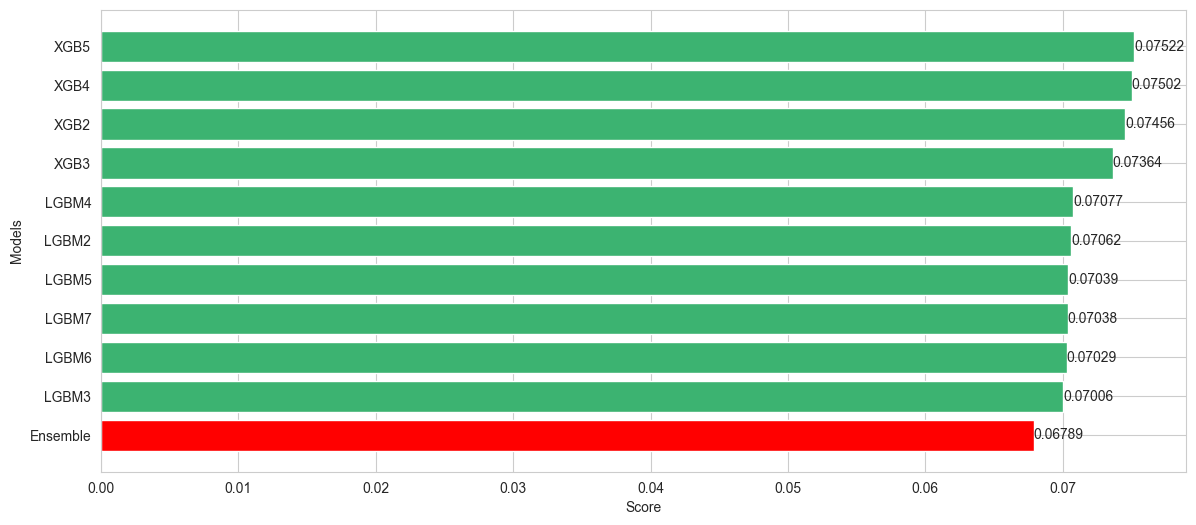

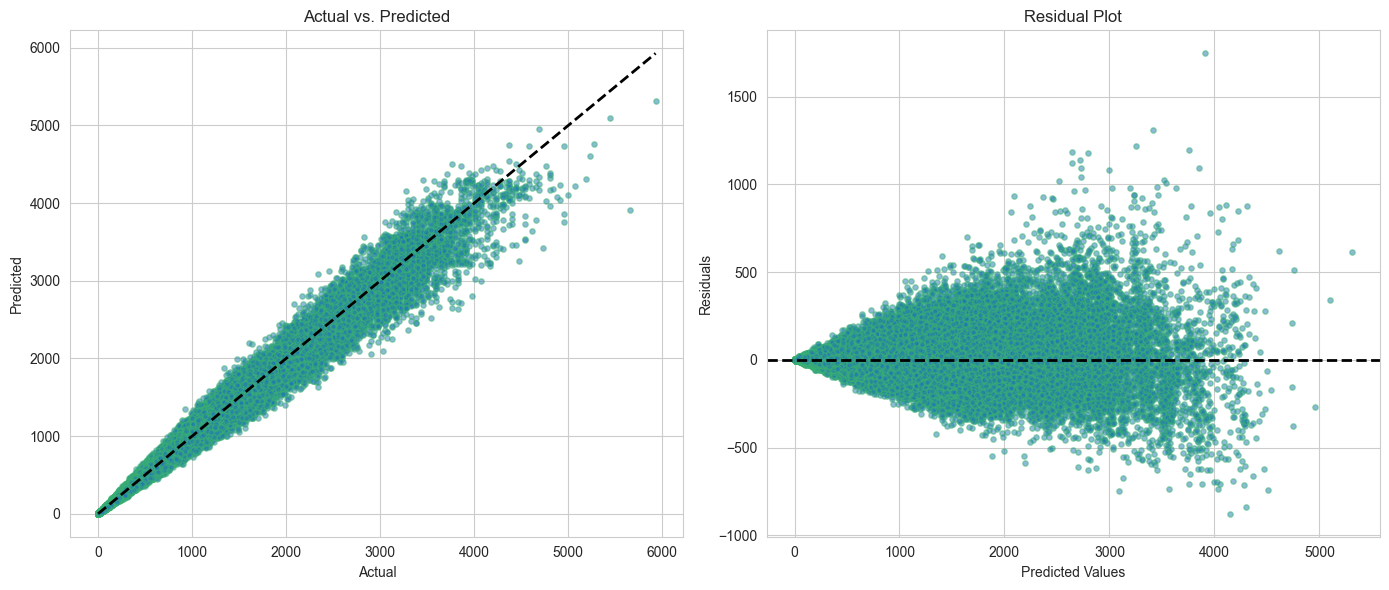

In [60]:
Config.model_round_ = 5
try:
    os.listdir(f'./submission_0/submissions_{Config.model_round_}')
except:
    os.makedirs(f'./submission_0/submissions_{Config.model_round_}')
try:
    model = Model(X, X_enc, y, test, test_enc, models)
    TEST_preds = model.train()
    submission = Config.submission
    submission[Config.target] = np.round(np.clip(1.0*np.expm1(TEST_preds['Ensemble'].values), 0, 6000))
    submission['pred_ensemble'] = TEST_preds['Ensemble'].values
    submission.to_csv(f'./submission_0/submissions_{Config.model_round_}/submission.csv', index=False)
    # model.TEST_preds.to_csv(f'./submission_0/submissions_{Config.model_round_}/submission_allmodel.csv', index=False)

except Exception as e:
    from samoyan_pack.messenger1 import messenger1
    messenger1("s51 err: " + str(e))
    print(e)
    raise e

In [53]:
model.TEST_preds

,CAT,CAT3
0,4.988036,4.950604
1,6.837700,6.820765
2,6.562584,6.546316
3,6.047549,6.017890
4,6.176049,6.146058
...,...,...
98545,5.956447,5.970506
98546,7.817033,7.823137
98547,7.681921,7.685364
98548,7.078335,7.061832


In [66]:
mean_absolute_percentage_error(
    np.expm1(prds["NN"]), t.train_raw["num_sold"].fillna(np.expm1(y))
)

0.12102320650950407

In [ ]:
# import matplotlib.pyplot as plt

# # Create the scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(
#     np.expm1(prds["NN"]),
#     t.train_raw["num_sold"],
#     color="#3cb371",
#     s=2,
#     label="Data Points",
# )

# # Add the diagonal line (y = x)
# plt.plot(
#     [t.train_raw["num_sold"].min(), t.train_raw["num_sold"].max()],
#     [t.train_raw["num_sold"].min(), t.train_raw["num_sold"].max()],
#     color="red",
#     linestyle="--",
#     linewidth=2,
#     label="y = x",
# )

# # Add labels and title
# plt.title("Actual vs Predicted Values")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.legend()
# plt.grid(True)
# plt.show()

In [42]:
model.TEST_preds
#.to_csv('submission_attention_with_extra_features.csv', index=False)


,NN,Ensemble
0,4.829722,4.830569
1,6.761064,6.743286
2,6.422156,6.407647
3,5.881106,5.871814
4,6.003620,5.993146
...,...,...
98545,5.850253,5.841259
98546,8.028462,7.998463
98547,7.896376,7.867650
98548,7.109423,7.088286


In [ ]:
t.test

In [ ]:
t.y

In [ ]:
test